In [1]:
#작업 순서
- 데이터준비 (정규화, 차수일치)
- 모델을 생성 ( Sequential, functional, Model)
    - layer를 활용(Conv2d, Dense, Flatten, MaxPooling2D)
- complie
- fitting
- save_weights, load_weights

SyntaxError: invalid syntax (<ipython-input-1-a22e514aa2f1>, line 3)

In [1]:
import numpy as np

from tensorflow.keras.models import Sequential
# channel, fillter, kernel, stride, padding
# 마지막이 FFNN
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
# 정규화 -> -0.5 ~ 0.5 학습이 용이
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5
# 원래 이미지 3차원 흑백 1바이트 60000X28X28 X1
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)
num_filters = 8 # 필터의 개수
filter_size = 3 # 사이즈 3X3
pool_size = 2 #  합침

In [3]:
model = Sequential([
    #1장의 사이즈를 기재
    Conv2D(num_filters, filter_size, input_shape=(28,28,1)),
    MaxPooling2D(pool_size=pool_size),
    Dropout(0.5), # 과적합을 방지하기 위해서 계산회로의 일부를 무작위로 제외
    Flatten(), # FFNN fully-connected
    Dense(64, activation='relu'),
    Dense(10, activation='softmax') #확률값
])

model.compile(
    'adam',
    loss = 'categorical_crossentropy',
    metrics=['accuracy']
)

In [4]:
model.fit(# train, validation, test
    train_images,
    to_categorical(train_labels), # 0.1
    epochs=3,
    validation_data=(test_images, to_categorical(test_labels))
)

Epoch 1/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3442 - accuracy: 0.8939 - val_loss: 0.1434 - val_accuracy: 0.9572
Epoch 2/3
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1699 - accuracy: 0.9475 - val_loss: 0.0877 - val_accuracy: 0.9729
Epoch 3/3
1875/1875 [==============================] - 8s 4ms/step - loss: 0.1291 - accuracy: 0.9598 - val_loss: 0.0786 - val_accuracy: 0.9755


In [5]:
model.save_weights('cnn.h5')

In [6]:
num_filters = 8
filter_size = 3
pool_size = 2
model = Sequential([
    Conv2D(num_filters, filter_size, input_shape=(28,28,1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model.load_weights('cnn.h5')

In [7]:
predictions = model.predict(test_images[:5]) #확률값
print(np.argmax(predictions, axis=1))

[7 2 1 0 4]


In [8]:
print(test_labels[:5])

[7 2 1 0 4]


In [ ]:
1352 * 10 + bias

# 왜 80인가
가중치 사이즈의 공간
8X3X3+8 bacth_size

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 8)         80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 8)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1352)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                86592     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 87,322
Trainable params: 87,322
Non-trainable params: 0
_________________________________________________________________


In [10]:
import tensorflow as tf
from tensorflow.keras import Model
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
print(x_train.shape) # 60000 28 28
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]
x_train.shape

(60000, 28, 28)


(60000, 28, 28, 1)

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train, y_train)).shuffle(10000).batch(32)

test_ds = tf.data.Dataset.from_tensor_slices((
    x_test, y_test)).batch(32)

In [12]:
# 재사용성이 높아지고 , debugging이 용이, design pattern을 사용
class MyModel(Model): # Sequential, functional, Model
    def __init__(self):
        super(MyModel, self).__init__() # 명시적으로 부모의 생성자를 호출
        self.conv1 = Conv2D(32,3,activation='relu') # 인스턴스
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu') # 특징 추출
        self.d2 = Dense(10, activation='softmax') # 출력
    def call(self, x): # 클래스를 함수처럼 호출가능
        x = self.conv1(x) # 실행
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)
model = MyModel()

In [13]:
# losses, metrics, optimizers wrapper 감싸게
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam() # runing rate 를 adaptive + zigzag : 가던방향을 고려해주면됨
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name = 'train_accuracy')
test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name = 'test_accuracy')

In [14]:
@tf.function # decorator 장식자 : debugging이 끝나기전에 달지 말아라
    # 최적화된 프로그램의 변수(상수화가능한)를 상수화해서 속도를 빠르게 실행
def train_step(images, labels):
    with tf.GradientTape() as tape: # 저장기능 : 변화량을 구하기 위해
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables) 
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)
    train_accuracy(labels, predictions)

In [15]:
@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    # 레이블 : [0,0,0,1,0,0,0,0,0] one- hot- encoding
    # predictions => softmax
    # [확률값 10개 나옴]
    # 3을 구하는 함수 argmax
    # 실제값 == 예측값 맞으면 True, 틀리면 False => 1인 것을 다 더하고 개수를 나누면 accuracy

In [16]:
EPOCHS = 5
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(images, labels)
    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)
    template = '에포크 : {}, 손실: {}, 정확도: {}, 테스트 손실: {}, 테스트 정확도: {}'
    print(template.format(epoch+1,
                         train_loss.result(),
                         train_accuracy.result()*100,
                         test_loss.result(),
                         test_accuracy.result()*100))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

에포크 : 1, 손실: 0.1362294703722, 정확도: 95.97166442871094, 테스트 손실: 0.05992317944765091, 테스트 정확도: 98.00999450683594
에포크 : 2, 손실: 0.08895789831876755, 정확도: 97.3258285522461, 테스트 손실: 0.05720425024628639, 테스트 정확도: 98.09500122070312
에포크 : 3, 손실: 0.06664854288101196, 정확도: 97.9705581665039, 테스트 손실: 0.05709094926714897, 테스트 정확도: 98.11666870117188
에포크 : 4, 손실: 0.05336311459541321, 정확도: 98.36917114257812, 테스트 손실: 0.05680856481194496, 테스트 정확도: 98.21749877929688
에포크 : 5, 손실: 0.04471927881240845, 정확도: 98.62200164794922, 

In [50]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist
#callbacks: 시스템(window)이 호출하는 함수 (마우스 이벤트 -)
#시스템에 있는 event queue에 담김)
#상황이나 상태에 따라 실행되는 함수

# Earlystopping : 좋은 학습의 신호는 cost값을 작아지게 하는 것
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

In [51]:
import numpy
numpy.random.seed(0)
tf.random.set_seed(3)
# 784, TARGET : 3
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() # 784 FFNN
# CNN 원래 이미지로 복원
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [70]:
from tensorflow.keras.optimizers import Adam
def bfn(optimizer = 'adam',learning_rate = 0.01):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])
    return model

In [71]:
from keras.wrappers.scikit_learn import KerasClassifier
new_model = KerasClassifier(build_fn=bfn, epochs=30, batch_size=200)

In [72]:
param_grid = {'optimizer' : ["Adam","RMSProp"],
             'learning_rate' : [0.0025,0.001]}
clf=GridSearchCV(estimator=new_model, param_grid=param_grid, cv=5)

In [73]:
clf.fit(X_train, Y_train, validation_data=(X_test, Y_test))

Epoch 1/30
240/240 [==============================] - 8s 35ms/step - loss: 0.9221 - acc: 0.7001 - val_loss: 0.1977 - val_acc: 0.9430
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.3020 - acc: 0.9137 - val_loss: 0.1331 - val_acc: 0.9603
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2267 - acc: 0.9355 - val_loss: 0.1014 - val_acc: 0.9701
Epoch 4/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1855 - acc: 0.9465 - val_loss: 0.0898 - val_acc: 0.9739
Epoch 5/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1585 - acc: 0.9556 - val_loss: 0.0861 - val_acc: 0.9747
Epoch 6/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1460 - acc: 0.9590 - val_loss: 0.0791 - val_acc: 0.9780
Epoch 7/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1309 - acc: 0.9629 - val_loss: 0.0764 - val_acc: 0.9787
Epoch 8/30
240/240 [==============================] - 8s 34ms/step - 

Epoch 1/30
240/240 [==============================] - 8s 34ms/step - loss: 0.9383 - acc: 0.6938 - val_loss: 0.2322 - val_acc: 0.9325
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.3382 - acc: 0.9032 - val_loss: 0.1396 - val_acc: 0.9590
Epoch 3/30
240/240 [==============================] - 8s 33ms/step - loss: 0.2370 - acc: 0.9329 - val_loss: 0.1134 - val_acc: 0.9654
Epoch 4/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1950 - acc: 0.9452 - val_loss: 0.0913 - val_acc: 0.9725
Epoch 5/30
240/240 [==============================] - 9s 36ms/step - loss: 0.1702 - acc: 0.9528 - val_loss: 0.0894 - val_acc: 0.9747
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1490 - acc: 0.9595 - val_loss: 0.0829 - val_acc: 0.9761
Epoch 7/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1352 - acc: 0.9626 - val_loss: 0.0803 - val_acc: 0.9777
Epoch 8/30
240/240 [==============================] - 8s 34ms/step - 

240/240 [==============================] - 8s 33ms/step - loss: 0.9243 - acc: 0.6939 - val_loss: 0.2185 - val_acc: 0.9340
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.3193 - acc: 0.9072 - val_loss: 0.1338 - val_acc: 0.9611
Epoch 3/30
240/240 [==============================] - 8s 33ms/step - loss: 0.2333 - acc: 0.9354 - val_loss: 0.0995 - val_acc: 0.9684
Epoch 4/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1922 - acc: 0.9461 - val_loss: 0.0819 - val_acc: 0.9746
Epoch 5/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1641 - acc: 0.9541 - val_loss: 0.0785 - val_acc: 0.9768
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1454 - acc: 0.9591 - val_loss: 0.0734 - val_acc: 0.9773
Epoch 7/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1346 - acc: 0.9622 - val_loss: 0.0698 - val_acc: 0.9801
Epoch 8/30
240/240 [==============================] - 8s 33ms/step - loss: 0.120

240/240 [==============================] - 8s 35ms/step - loss: 0.9788 - acc: 0.6844 - val_loss: 0.2566 - val_acc: 0.9266
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.3519 - acc: 0.8979 - val_loss: 0.1943 - val_acc: 0.9395
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2435 - acc: 0.9300 - val_loss: 0.1109 - val_acc: 0.9660
Epoch 4/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1914 - acc: 0.9456 - val_loss: 0.0991 - val_acc: 0.9722
Epoch 5/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1627 - acc: 0.9551 - val_loss: 0.0851 - val_acc: 0.9735
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1382 - acc: 0.9613 - val_loss: 0.0845 - val_acc: 0.9762
Epoch 7/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1289 - acc: 0.9650 - val_loss: 0.0758 - val_acc: 0.9785
Epoch 8/30
240/240 [==============================] - 8s 34ms/step - loss: 0.114

240/240 [==============================] - 8s 35ms/step - loss: 0.9418 - acc: 0.6941 - val_loss: 0.2006 - val_acc: 0.9403
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.3108 - acc: 0.9115 - val_loss: 0.1276 - val_acc: 0.9608
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2124 - acc: 0.9405 - val_loss: 0.0953 - val_acc: 0.9716
Epoch 4/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1676 - acc: 0.9535 - val_loss: 0.0878 - val_acc: 0.9731
Epoch 5/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1406 - acc: 0.9609 - val_loss: 0.0761 - val_acc: 0.9766
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1234 - acc: 0.9655 - val_loss: 0.0777 - val_acc: 0.9773
Epoch 7/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1124 - acc: 0.9693 - val_loss: 0.0674 - val_acc: 0.9786
Epoch 8/30
240/240 [==============================] - 8s 34ms/step - loss: 0.103

240/240 [==============================] - 8s 35ms/step - loss: 0.8523 - acc: 0.7183 - val_loss: 0.1651 - val_acc: 0.9508
Epoch 2/30
240/240 [==============================] - 8s 35ms/step - loss: 0.2668 - acc: 0.9233 - val_loss: 0.1156 - val_acc: 0.9665
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1936 - acc: 0.9440 - val_loss: 0.0933 - val_acc: 0.9709
Epoch 4/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1615 - acc: 0.9548 - val_loss: 0.0796 - val_acc: 0.9768
Epoch 5/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1399 - acc: 0.9608 - val_loss: 0.0707 - val_acc: 0.9785
Epoch 6/30
240/240 [==============================] - 9s 36ms/step - loss: 0.1226 - acc: 0.9654 - val_loss: 0.0757 - val_acc: 0.9786
Epoch 7/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1147 - acc: 0.9680 - val_loss: 0.0666 - val_acc: 0.9793
Epoch 8/30
240/240 [==============================] - 8s 35ms/step - loss: 0.104

240/240 [==============================] - 9s 36ms/step - loss: 0.9141 - acc: 0.7083 - val_loss: 0.1945 - val_acc: 0.9423
Epoch 2/30
240/240 [==============================] - 9s 36ms/step - loss: 0.3053 - acc: 0.9122 - val_loss: 0.1356 - val_acc: 0.9589
Epoch 3/30
240/240 [==============================] - 9s 36ms/step - loss: 0.2236 - acc: 0.9376 - val_loss: 0.1109 - val_acc: 0.9661
Epoch 4/30
240/240 [==============================] - 9s 36ms/step - loss: 0.1857 - acc: 0.9477 - val_loss: 0.0962 - val_acc: 0.9700
Epoch 5/30
240/240 [==============================] - 9s 37ms/step - loss: 0.1622 - acc: 0.9550 - val_loss: 0.0819 - val_acc: 0.9762
Epoch 6/30
240/240 [==============================] - 9s 39ms/step - loss: 0.1418 - acc: 0.9606 - val_loss: 0.0758 - val_acc: 0.9777
Epoch 7/30
240/240 [==============================] - 9s 37ms/step - loss: 0.1315 - acc: 0.9638 - val_loss: 0.0822 - val_acc: 0.9763
Epoch 8/30
240/240 [==============================] - 9s 36ms/step - loss: 0.122

240/240 [==============================] - 8s 34ms/step - loss: 0.9704 - acc: 0.6772 - val_loss: 0.2347 - val_acc: 0.9317
Epoch 2/30
240/240 [==============================] - 8s 35ms/step - loss: 0.3258 - acc: 0.9030 - val_loss: 0.1358 - val_acc: 0.9589
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2381 - acc: 0.9326 - val_loss: 0.1173 - val_acc: 0.9641
Epoch 4/30
240/240 [==============================] - 8s 33ms/step - loss: 0.1965 - acc: 0.9446 - val_loss: 0.0978 - val_acc: 0.9711
Epoch 5/30
240/240 [==============================] - 8s 33ms/step - loss: 0.1687 - acc: 0.9535 - val_loss: 0.0922 - val_acc: 0.9724
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1535 - acc: 0.9570 - val_loss: 0.0940 - val_acc: 0.9729
Epoch 7/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1382 - acc: 0.9625 - val_loss: 0.0762 - val_acc: 0.9765
Epoch 8/30
240/240 [==============================] - 8s 34ms/step - loss: 0.125

C:\Users\020\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\020\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\020\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 209, in fit
    return super(KerasClassifier, self).fit(x, y, **kwargs)
  File "C:\Users\020\anaconda3\lib\site-packages\keras\wrappers\scikit_learn.py", line 151, in fit
    history = self.model.fit(x, y, **fit_args)
  File "C:\Users\020\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 66, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\020\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py", line 848, in fit
   

Epoch 1/30
240/240 [==============================] - 8s 33ms/step - loss: 0.9499 - acc: 0.6856 - val_loss: 0.2570 - val_acc: 0.9248
Epoch 2/30
240/240 [==============================] - 8s 33ms/step - loss: 0.3394 - acc: 0.9005 - val_loss: 0.1493 - val_acc: 0.9541
Epoch 3/30
240/240 [==============================] - 8s 35ms/step - loss: 0.2364 - acc: 0.9336 - val_loss: 0.1096 - val_acc: 0.9683
Epoch 4/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1856 - acc: 0.9482 - val_loss: 0.0948 - val_acc: 0.9719
Epoch 5/30
240/240 [==============================] - 8s 33ms/step - loss: 0.1601 - acc: 0.9556 - val_loss: 0.0848 - val_acc: 0.9751
Epoch 6/30
240/240 [==============================] - 8s 35ms/step - loss: 0.1423 - acc: 0.9607 - val_loss: 0.0772 - val_acc: 0.9772
Epoch 7/30
240/240 [==============================] - 9s 36ms/step - loss: 0.1301 - acc: 0.9644 - val_loss: 0.0774 - val_acc: 0.9768
Epoch 8/30
240/240 [==============================] - 8s 35ms/step - 

240/240 [==============================] - 8s 34ms/step - loss: 1.0041 - acc: 0.6717 - val_loss: 0.2725 - val_acc: 0.9204
Epoch 2/30
240/240 [==============================] - 8s 34ms/step - loss: 0.4027 - acc: 0.8823 - val_loss: 0.1844 - val_acc: 0.9427
Epoch 3/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2712 - acc: 0.9227 - val_loss: 0.1261 - val_acc: 0.9636
Epoch 4/30
240/240 [==============================] - 8s 34ms/step - loss: 0.2144 - acc: 0.9390 - val_loss: 0.1042 - val_acc: 0.9679
Epoch 5/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1797 - acc: 0.9499 - val_loss: 0.0811 - val_acc: 0.9757
Epoch 6/30
240/240 [==============================] - 8s 34ms/step - loss: 0.1519 - acc: 0.9585 - val_loss: 0.0778 - val_acc: 0.9773
Epoch 7/30
240/240 [==============================] - 9s 38ms/step - loss: 0.1362 - acc: 0.9631 - val_loss: 0.0705 - val_acc: 0.9787
Epoch 8/30
240/240 [==============================] - 11s 44ms/step - loss: 0.12

C:\Users\020\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.98515 0.98435 0.98515     nan]
  warnings.warn(


Epoch 1/30
300/300 [==============================] - 10s 34ms/step - loss: 0.8710 - acc: 0.7194 - val_loss: 0.2070 - val_acc: 0.9380
Epoch 2/30
300/300 [==============================] - 10s 34ms/step - loss: 0.3111 - acc: 0.9125 - val_loss: 0.1393 - val_acc: 0.9601
Epoch 3/30
300/300 [==============================] - 10s 34ms/step - loss: 0.2248 - acc: 0.9360 - val_loss: 0.1033 - val_acc: 0.9682
Epoch 4/30
300/300 [==============================] - 10s 33ms/step - loss: 0.1902 - acc: 0.9465 - val_loss: 0.0866 - val_acc: 0.9729
Epoch 5/30
300/300 [==============================] - 10s 33ms/step - loss: 0.1650 - acc: 0.9542 - val_loss: 0.0899 - val_acc: 0.9733
Epoch 6/30
300/300 [==============================] - 10s 33ms/step - loss: 0.1516 - acc: 0.9582 - val_loss: 0.0753 - val_acc: 0.9785
Epoch 7/30
300/300 [==============================] - 10s 33ms/step - loss: 0.1349 - acc: 0.9629 - val_loss: 0.0744 - val_acc: 0.9778
Epoch 8/30
300/300 [==============================] - 10s 33ms

GridSearchCV(cv=5,
             estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000001ACB30CFCD0>,
             param_grid={'learning_rate': [0.0025, 0.001],
                         'optimizer': ['Adam', 'RMSProp']})

In [74]:
clf.best_params_

{'learning_rate': 0.0025, 'optimizer': 'Adam'}

In [20]:
# import os
# MODEL_DIR = '/model/'
# if not os.path.exists(MODEL_DIR):
#     os.mkdir(MODEL_DIR)
# modelpath ="./model/{epoch:02d}-{val_loss:.4f}.hdf5"
# # val_loss가 이전값보다 좋을 때 저장
# checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1, save_best_only=True)
# # 최적점을 찾아서 스톱
# early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
import os

MODEL_DIR = '.\\model\\'

if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = '.\\model\\weights.{epoch:02d}-{val_loss:.2f}.hdf5'
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', verbose=1,
                               save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)

In [21]:
history = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=30,
                   batch_size=200, verbose=0,
                   callbacks=[early_stopping_callback, checkpointer])


Epoch 00001: val_loss improved from inf to 0.13262, saving model to .\model\weights.01-0.13.hdf5

Epoch 00002: val_loss improved from 0.13262 to 0.08711, saving model to .\model\weights.02-0.09.hdf5

Epoch 00003: val_loss improved from 0.08711 to 0.07756, saving model to .\model\weights.03-0.08.hdf5

Epoch 00004: val_loss improved from 0.07756 to 0.06143, saving model to .\model\weights.04-0.06.hdf5

Epoch 00005: val_loss did not improve from 0.06143

Epoch 00006: val_loss did not improve from 0.06143

Epoch 00007: val_loss improved from 0.06143 to 0.05616, saving model to .\model\weights.07-0.06.hdf5

Epoch 00008: val_loss did not improve from 0.05616

Epoch 00009: val_loss did not improve from 0.05616

Epoch 00010: val_loss did not improve from 0.05616

Epoch 00011: val_loss improved from 0.05616 to 0.05292, saving model to .\model\weights.11-0.05.hdf5

Epoch 00012: val_loss did not improve from 0.05292

Epoch 00013: val_loss did not improve from 0.05292

Epoch 00014: val_loss impro

313/313 [==============================] - 1s 3ms/step - loss: 0.0596 - acc: 0.9868

Test Accuracy: 0.9868


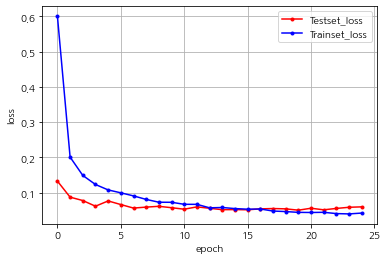

In [22]:
print("\nTest Accuracy: %.4f" % (model.evaluate(X_test, Y_test)[1]))
y_vloss= history.history['val_loss']
y_loss = history.history['loss']
x_len = numpy.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c="red", label='Testset_loss')
plt.plot(x_len, y_loss, marker='.', c="blue", label='Trainset_loss')
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# 문제 mnist 파라미터 튜닝을 진행하시오
- optimizer와 learning-rate에 대하여 튜닝을 실시하시오
    -최적의 파라미터를 출력
- accuracy 그래프를 출력하세요

In [ ]:
import numpy
numpy.random.seed(0)
tf.random.set_seed(3)
# 784, TARGET : 3
(X_train, Y_train), (X_test, Y_test) = mnist.load_data() # 784 FFNN
# CNN 원래 이미지로 복원
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32') / 255
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32') / 255
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

In [ ]:
def bfn(optimizer = 'adam',learning_rate = 0.01):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), input_shape=(28, 28, 1), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer(learning_rate=learning_rate),
                  metrics=['acc'])
    return model

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

new_model = KerasClassifier(build_fn=bfn, epochs=30, batch_size=200)

param_grid = {'optimizer' : ["Adam","SGD"],
             'learning_rate' : [0.001,0.01],
             'validation_data': [(x_te, y_te)],
             'callbacks': [early_stopping_callback]}

clf=GridSearchCV(estimator=new_model, param_grid=param_grid, n_jobs=-1, verbose=0)

clf.fit(x_tr, y_tr)